# RL coursework, part IV (30 pts in total)

---

**Name:** Yan-Ting Chen

**SN:** 22092176

---

**Due date:** *27 March, 2023*

---

Standard UCL policy (including grade deductions) automatically applies for any late submissions.

## How to submit

When you have completed the exercises and everything has finished running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **`<studentnumber>_RL_part4.ipynb`** before the deadline above, where `<studentnumber>` is your student number.

### Objectives

#### Q.1: You will implement a number of off-policy multi-step return estimates, and answer questions about their accuracy.

#### Q.2: You will be looking at other, TD-like, updates to learn the value function. You will be asked to investigate different properties of these: e.g. convergence properties, variance of updates. This is akin to a typical analysis one would undertaken when proposing a new update rule to learn value functions.


## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

/var/folders/jr/qpthpts51n9f081jrcbyh3vc0000gn/T/ipykernel_24588/3253540646.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-notebook')


## Q1 [11 points total]
For many concrete algorithms, we need to combine multi-step updates with off-policy corrections.  The multi-step updates are necessary for efficient learning, while the off-policy corrections are necessary to learn about multiple things at once, or to correct for a distribution mismatch (e.g., when trying to perform a policy-gradient update from logged data).

In this section, you will implement various different returns with off-policy corrections.  The next cell has two examples *without* corrections.  These examples compute equivalent returns, but compute those returns in different ways.  These are provided as reference implementations to help you.

Note that the implementations both allow for immediate bootstrapping on the current state value. This is unconventional (most literature only allows the first bootstrapping to happen after the first step), but we will use this convention in all implementations below for consistency. 

In [3]:
#@title On-policy return computations

def on_policy(observations, actions, pi, mu, rewards, discounts,
              trace_parameter, v_fn):
  """Compute on-policy return recursively."""
  del mu  # The policy probabilities are ignored by this function
  del pi
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))
  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    # There are T+1 observations, but only T rewards, and the indexing here
    # for the rewards is off by one compared to the indexing in the slides
    # and in Sutton & Barto.  In other words, r[t] == R_{t+1}.
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return (1 - l)*v + l*G

def on_policy_error_recursion(observations, actions, pi, mu, rewards, discounts,
                              trace_parameter, v_fn):
  del pi  # The target policy probabilities are ignored by this function
  del mu  # The behaviour policy probabilities are ignored by this function
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  errors = np.zeros((T,))
    
  error = 0.
  # recurse backwards to calculate errors
  for t in reversed(range(T)):
    error = r[t] + d[t]*v[t + 1] - v[t] + d[t]*l*error
    errors[t] = error
  v = v[:-1]  # Remove (T+1)th observation before calculating the returns
  return v + l*errors

### Q 1.1 [5 points]
Implement the return functions below and run the cells below that.

In [4]:
def full_importance_sampling(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with full importance-sampling corrections, so that
  the return G_t is corrected with the full importance-sampling correction of
  the rest of the trajectory.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))

  rho = np.cumprod(pi[::-1] / mu[::-1])[::-1]

  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    if t == T - 1:
      G[t] = r[t] + d[t]*v[t + 1]
    else:
      G[t] = r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])
  v = v[:-1]

  return (1 - l)*v + rho * l*G
  

def per_decision(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with per-decision importance-sampling corrections.
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))

  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    rho = pi[t] / mu[t]

    if t == T - 1:
      G[t] = rho * (r[t] + d[t]*v[t + 1])
    else:
      G[t] = rho * (r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1]))
  v = v[:-1]

  return (1 - l)*v + l*G

def control_variates(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))

  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    rho = pi[t] / mu[t]

    if t == T - 1:
      G[t] = rho * (r[t] + d[t]*v[t + 1]) + (1 - rho) * v[t]
    else:
      G[t] = rho * (r[t] + d[t]*((1 - l)*v[t + 1] + l*G[t + 1])) + (1 - rho) * v[t]
  v = v[:-1]

  return (1 - l)*v + l*G

def adaptive_bootstrapping(observations, actions, pi, mu, rewards, discounts, trace_parameter, v_fn):
  """
  Compute off-policy return with 
  1. per-decision importance-sampling corrections, and
  2. control variates, and
  3. adaptive bootstrapping.

  Implement the adaptive bootstrapping with an *additional* trace parameter
  lambda, such that lambda_t = lambda * min(1, 1/rho_t).
  """
  T = len(rewards)  # number of transitions
  r = rewards
  d = discounts
  l = trace_parameter
  v = np.array([v_fn(o) for o in observations])
  G = np.zeros((T,))

  # recurse backwards to calculate returns
  for t in reversed(range(T)):
    rho = pi[t] / mu[t]
    l_t = l * min(1.0, 1.0 / rho)

    if t == T - 1:
      G[t] = rho * (r[t] + d[t]*v[t + 1]) + (1 - rho) * v[t]
    else:
      G[t] = rho * (r[t] + d[t]*((1 - l_t)*v[t + 1] + l_t*G[t + 1])) + (1 - rho) * v[t]
  v = v[:-1]

  return (1 - l_t)*v + l_t*G



In [29]:
#@title (Run, don't modify) Functions to generate experience, compute values
MU_RIGHT = 0.5
PI_RIGHT = 0.9
NUMBER_OF_STEPS = 5
DISCOUNT = 0.99

def generate_experience():
  r"""Generate experience trajectories from a tabular tree MDP.

  This function will start in state 0, and will then generate actions according
  to a uniformly random behaviour policy.  When A_t == 0, the action will be to
  the left, with A_t==1, it will be to the right.  The states are nunmbered as
  depicted below:
          0
         / \
        1   2
       / \ / \
      3   4   5
         ...
  
  Args:
      number_of_steps: the number of total steps.
      p_right: probability of the behaviour to go right.

  Returns:
      A dictionary with elements:
        * observations (number_of_steps + 1 integers): the
          observations are just the actual (integer) states
        * actions (number_of_steps integers): actions per step
        * rewards (number_of_steps scalars): rewards per step
        * discounts (number_of_steps scalars): currently always 0.9,
          except the last one which is zero
        * mu (number_of_steps scalars): probability of selecting each
          action according to the behavious policy
        * pi (number_of_steps scalars): probability of selecting each
          action according to the target policy (here p(1) = 0.9 and
          p(0) = 0.1, where a==1 implies we go 'right')
  """
  # generate actions
  actions = np.array(np.random.random(NUMBER_OF_STEPS,) < MU_RIGHT,
                     dtype=np.int)
  s = 0
  # compute resulting states
  states = np.cumsum(np.arange(1, NUMBER_OF_STEPS + 1) + actions)
  states = np.array([0] + list(states))  # add start state

  # in this case, observations are just the real states
  observations = states

  # generate rewards
  rewards     = 2.*actions - 1. # -1 for left, +1 for right, 
  rewards[-1] = np.sum(actions)  # extra final reward for going right
    
  # compute discounts
  discounts     = DISCOUNT * np.ones_like(rewards)
  discounts[-1] = 0.  # final transition is terminal, has discount=0

  # determine target and behaviour probabilities for the selected actions
  pi = np.array([1. - PI_RIGHT, PI_RIGHT])[actions] # Target probabilities
  mu = np.array([1. - MU_RIGHT, MU_RIGHT])[actions] # Behaviour probabilities
    
  return dict(observations=observations,
              actions=actions,
              pi=pi,
              mu=mu,
              rewards=rewards,
              discounts=discounts)

def true_v(s, pi, number_of_steps):
  """Compute true state value recursively."""
  depth = int(np.floor((np.sqrt(1 + 8*s) - 1)/2))
  position = int(s - depth*(depth+1)/2)
  remaining_steps = number_of_steps - depth
  final_reward = DISCOUNT**(remaining_steps-1)*(position + pi*remaining_steps)
  reward_per_step = pi*(+1) + (1 - pi)*(-1)
  discounted_steps = (1 - DISCOUNT**(remaining_steps - 1))/(1 - DISCOUNT)
  reward_along_the_way = reward_per_step * discounted_steps
  return reward_along_the_way + final_reward



/var/folders/jr/qpthpts51n9f081jrcbyh3vc0000gn/T/ipykernel_24588/3359063109.py:41: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


[ 18.633 819.207 243.753   7.887   0.799]


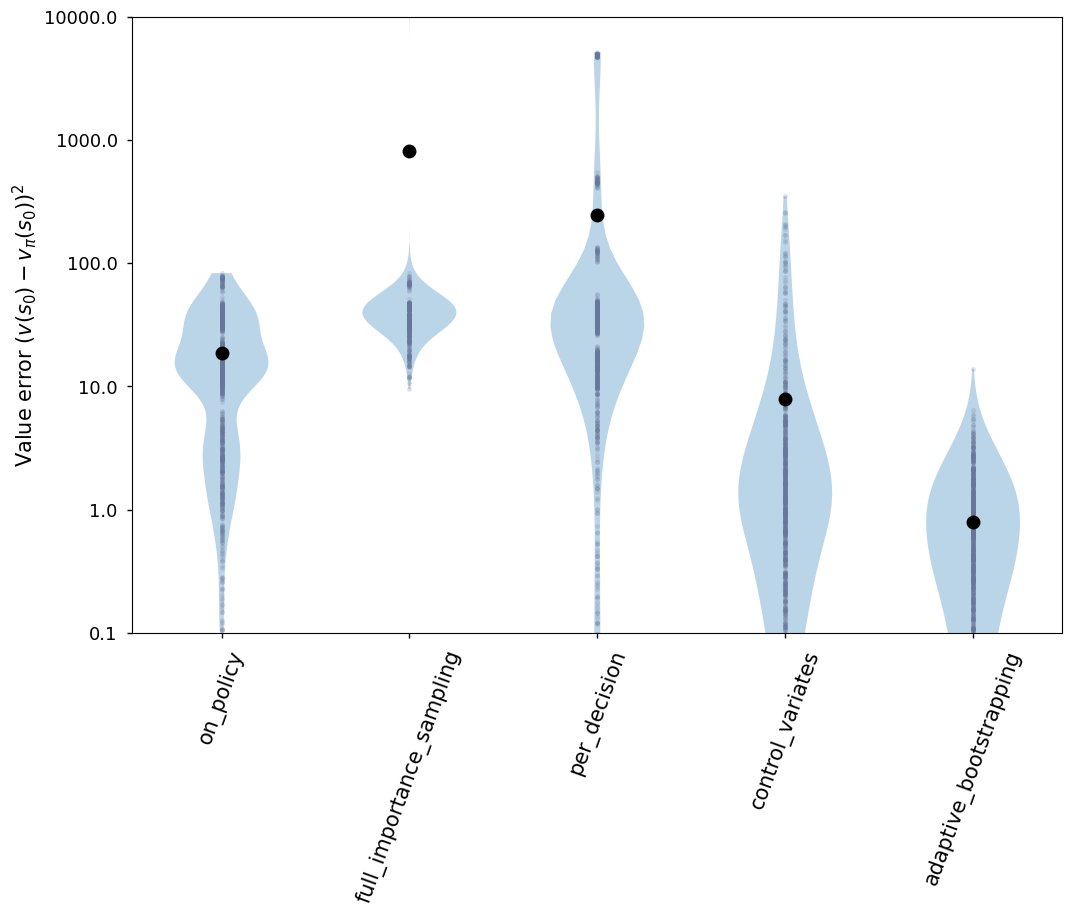

In [35]:
#@title Run experiment (don't modify)
algs = ['on_policy', 'full_importance_sampling', 'per_decision', 'control_variates', 'adaptive_bootstrapping']

# Precompute state values (for efficiency)
N = NUMBER_OF_STEPS
true_vs = [true_v(s, PI_RIGHT, N) for s in range((N+1)*(N+2)//2)]

def random_v(iteration, s):
  rng = np.random.RandomState(seed=s + iteration*10000)
  return true_vs[s] + rng.normal(loc=0, scale=1.)  # Add fixed random noise 

def plot_errors(ax, errors):
  errors = np.array(errors)
  ax.violinplot(np.log10(errors), showextrema=False)
  ax.plot(range(1, len(algs)+1), np.log10(errors).T,
          '.', color='#667799', ms=7, alpha=0.2)
  ax.plot(range(1, len(algs)+1), np.log10(np.mean(errors, axis=0)),
          '.', color='#000000', ms=20)
  ax.set_yticks(np.arange(-2, 5))
  ax.set_yticklabels(10.**np.arange(-2, 5), fontsize=13)
  ax.set_ylabel("Value error $(v(s_0) - v_{\\pi}(s_0))^2$", fontsize=15)
  ax.set_xticks(range(1, len(algs)+1))
  ax.set_xticklabels(algs, fontsize=15, rotation=70)
  ax.set_ylim(-1, 4)

fig = plt.figure(figsize=(12, 8))

errors = []
estimates = []
v0 = true_vs[0]
for iteration in range(1000):
  errors.append([])
  estimates.append([])
  trajectory = generate_experience()
  for alg in algs:
    estimate = eval(alg)(**trajectory,
                        v_fn=lambda s: random_v(iteration, s),
                        trace_parameter=0.9)
    errors[-1].append((estimate[0] - v0)**2)
print(np.mean(errors, axis=0))
plot_errors(plt.gca(), errors)

Above, the distributions of mean squared value errors are shown, with the mean as a big black dot and the (1,000) individual return samples as small black dots.

### Q 1.2 [3 points]
Explain the ranking in terms of value error of the different return estimates.

> In terms of value error, we can find that *full_importance_sampling* (off-policy method) is the worst performing algorithm ($5^{th}$) as it utilizes two different policies (target policy & behavior policy) and correct the expected value with *importance sampling ratio*, which induced greater variance (value error) comparing with other methods. The $4^{th}$ algorithm is *per_decision* (off-policy method), which is a lower-variance version of *full_importance_sampling* since it takes into account the fact that reward samples come from MPD. The $3^{rd}$ algorithm is *on_policy*. The $2^{nd}$ algorithm is *control_variates*, which is a enhanced method on the basis of *per_decision* by including control variates term $(1-\rho _t)v(S_t)$ so as to further reduce variance. The $1^{st}$ algorithm is *adaptive_bootstrapping*, which is the combination of *per_decision* and *control_variates*. On top of these, it let trace parameter $\lambda _t$ depend on $\rho _t$ in order to adaptively adjust the level of "bootstrapping", balancing the trade-off between "high variance" and "deadly-triad".



### Q 1.3 [3 points]
Could there be a reason to **not** choose the best return according to this ranking when learning off-policy?  Explain your answer.

> --(Probably Wrong, if you know the correct answer, please let me know)--
It is important to note that the ranking is evaluated and restricted to MDP problems. In different environments, where the "deadly-triad" of instability, high variance, and bias in value estimations can pose risks, it may be necessary to trade off some performance in terms of estimated returns. This trade-off involves carefully considering the balance between "off-policy" behavior and the use of 'bootstrapping' techniques to manage the potential risks.

## Q2 [19 points total]
 Consider a MDP $M = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$ and a behaviour policy $\mu$. We use policy $\mu$ to generate trajectories of experience:
\begin{equation*}
    (s_{t}, a_{t}, r_{t},s_{t+1}, a_{t+1}, r_{t+1},\cdots, s_{t+n-1}, a_{t+n-1}, r_{t+n-1}, s_{t+n}, a_{t+n}) \,.
\end{equation*}
Note that this is an $n$-step sequence, starting from time $t$.

Given these partial trajectories we consider the following learning problems:




### Q2.1 [9 points]
Consider a learning update based on the following temporal difference error:
$$\delta_t = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)$$

Consider updating a tabular action value function with TD.

i) Does the resulting value function converge, under any initialisation of the value function? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove the convergence under infinity number of interactions with this MDP, under fixed behaviour policy $\mu$ and show its convergence point. If not, show why it diverges. (7 points)

ii) Under which conditions, would the above process converge to the optimal value function $q_*$ ? (2 points)

>i)
> Suppose $P$ is the transition probability matrix for the MDP. Let $T$ be the space of bounded real-valued functions over $S \times A$. For any policy $\pi$, we define $$(T^\pi_Q f)(s,a) = \sum_{s',s'' \in S} P(s', s)[R(s, a) + \gamma R(s', a') + \gamma^2 \max_a q(s'', a)]$$
> $$||T^\pi q_1(s,a) - T^\pi q_2(s,a)||_{\infty} = \max_{s,a} |\sum_{s',s'' \in S}P(s', s)[R(s, a) + \gamma R(s', a') + \gamma^2 \max_a q_1(s'', a) - R(s, a) - \gamma R(s', a') - \gamma^2 \max_a q_2(s'', a)]|$$
> $$= \gamma^2 \max_{s,a} |\sum_{s',s'' \in S}P(s', s)[\max_a q_1(s'', a) - \max_a q_2(s'', a)]|$$
> $$\leq \gamma^2\max_{s,a} \sum_{s',s'' \in S}P(s', s)|| q_1(s'', a) - q_2(s'', a)||_{\infty} = \gamma^2 || q_1(s'', a) - q_2(s'', a)||_{\infty}$$
> From the above result, we know $T$ is **$\gamma^2$-contraction** wrt. $||\cdot||_{\infty}$. Later, we will utilize it and [1] to prove the convergence of value function wrt. $\delta_t$. 
> For the update formula of the action function $q$:
> $$q_{t+1}(S_t, A_t) = q(S_t, A_t) + \alpha_t \delta_t = q(S_t, A_t) + \alpha_t [R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q(S_t, A_t)]$$
> $$ = (1 - \alpha_t)q(S_t, A_t) + \alpha_t [R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a)]$$
> Subtracting from both sides the quantity $q^*(S_t,A_t)$ and letting $ \Delta_t (s, a) = q(s, a) - q^*(s, a)$
> $$ \Delta_t (S_t, A_t) = (1-\alpha_t)\Delta_t(S_t, A_t) + \alpha_t[R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q^*(S_t, A_t)]$$
> Rewriting $F_t(S_t,A_t) = R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q^*(S_t, A_t)$
> $$\mathbb{E}[F_t(S_t,A_t)|\mathcal{F_t}] = P(S_{t+1}, S_t)[R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q^*(S_t, A_t)]= T^\pi q(S_t,A_t) - q^*(S_t, A_t)$$
> Using the fact that $q = T^\pi q$, $T$ is $\gamma^2$-contraction wrt. $||\cdot||_{\infty}$,
> $$||T^\pi q(S_t,A_t) - q^*(S_t, A_t)|| \leq \gamma^2 ||q(S_t,A_t) - q_2(S_t,A_t)||_{\infty}$$
> $$var[F_t(S_t,A_t)|\mathcal{F_t}] = \mathbb{E}[(R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a) - q^*(S_t, A_t) - T^\pi q(S_t,A_t) + q^*(S_t, A_t))^2]$$
> $$=var[R(S_t, A_t) + \gamma R(S_{t+1}, A_{t+1}) + \gamma^2 \max_a q(S_{t+2}, a)|\mathcal{F_t}] \leq C(1+||\Delta_t||)^2$$
> With the help of Theorem in [1], we know that $\gamma^2 ||q(S_t,A_t) - q_2(S_t,A_t)||_{\infty}$ **converge** to $0$ under the condition (1)$\sum_t \alpha_t = \infty$, $\sum_t \alpha_t^2 < \infty$, and (2)$\gamma^2 \in [0, 1)$.
>
>ii)
> As mentioned in Q2.1.i), the conditions for convergence to $q_*$ are (1)$\sum_t \alpha_t = \infty$, $\sum_t \alpha_t^2 < \infty$, and (2)$\gamma^2 \in [0, 1)$ for the MDP.
>
>Reference: 
>[1] Theorem 1 in Section 2.1, Tommi Jaakkola, Michael I. Jordan, and Satinder P. Singh. On the con- vergence of stochastic iterative dynamic programming algorithms. Neural Computation, 6(6):1185–1201, 1994.


### Q2.2 [10 points]

Consider the same questions now for the following temporal difference error
\begin{equation}
        \delta_t = r(S_{t},A_{t}) + \gamma \frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)
\end{equation}

where $\pi(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$ and consider the behaviour policy to be either:

  a. $\mu(a|s) \in \arg\max_a q(s,a), \forall s,a \in \mathcal{A} \times \mathcal{S}$,
  
  b. $\mu(a|s) = \frac{1}{|\mathcal{A}|}$ (uniformly random policy).

Answer the below two questions for **both choices** of the behaviour policy $\mu$:
* i)  Does updating a tabular action value function with this TD error converge to the optimal value function $q_*$? Consider an appropiate learning rate (Robbins–Monro conditions). If so, prove this convergence under infinity number of interaction with this MDP, under behaviour policy $\mu$. If not, show why it diverges or alternatively convergence to a different solution. (4 points)

* ii) How does the variance of this update compare to the one induced by the error in Q2.1? (3 points). 
* iii) Can you propose a different behaviour policy that achieves a lower variance than any of the choices we considered for $\mu$? Prove that your behaviour policy achieve this. Argue why, if that is not possible. (3 points)

*Answer here:*
> i)--(Probably Wrong, if you know the correct answer, please let me know)--
>
> For behavior policy $\mu(a|s) \in \arg\max_a q(s,a)$, it can **converge**, and the convergence conditions is similar to Q2.1 since $\mu(a|s) = \pi(a|s)$. (i.e. (1)$\sum_t \alpha_t = \infty$, $\sum_t \alpha_t^2 < \infty$, and (2)$\gamma^2 \in [0, 1)$).
>
> For behavior policy $\mu(a|s) = \frac{1}{|\mathcal{A}|}$, $\frac{\pi(A_{t+1}|S_{t+1})}{\mu(A_{t+1}|S_{t+1})} = |\mathcal{A}|$, and then we can obtain
> $$\delta_t = r(S_{t},A_{t}) + \gamma |\mathcal{A}| \left[ r(S_{t+1},A_{t+1}) + \gamma \max_{a} q(S_{t+2},a) \right] - q(S_t, A_t)$$
> Using the similar method to prove this, we can know the it can also **converge** under the condition that (1)$\sum_t \alpha_t = \infty$, $\sum_t \alpha_t^2 < \infty$, and (2)$\gamma^2|\mathcal{A}| \in [0, 1)$
>
>ii)
>
>For behavior policy $\mu(a|s) \in \arg\max_a q(s,a)$, the variance should be lower as $\mu(a|s) = \pi(a|s)$ (no need for off-policy correction). 
>
>For behavior policy $\mu(a|s) = \frac{1}{|\mathcal{A}|}$, the variance might be higher since the value of $|\mathcal{A}|$ might let variance of $\delta_t$ larger.
>
> iii)
> --(Probably Wrong, if you know the correct answer, please let me know)--
> One approach to reduce variance in a behavior policy is to make it more deterministic (reduce exploration).